In [1]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
# embed the figures into the notebook
%matplotlib inline

In [2]:
u_inf = 1.0  

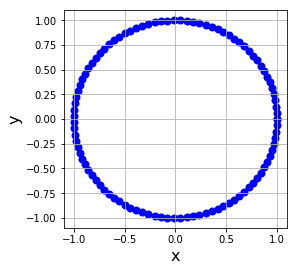

In [3]:
R = 1.0
x_center, y_center = 0.0, 0.0
theta = numpy.linspace(0.0, 2 * math.pi, 100)
x_cylinder, y_cylinder = (x_center + R * numpy.cos(theta),y_center + R * numpy.sin(theta))
size = 4
pyplot.figure(figsize=(size, size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.scatter(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=2)
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

In [4]:
class Panel:
    def __init__(self,xa,ya,xb,yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2
        self.length = math.sqrt((xb - xa)**2 + (yb - ya)**2)
        
        if xb - xa <= 0.:
            self.beta = math.acos((yb - ya) / self.length)
        elif xb - xa > 0.:
            self.beta = math.pi + math.acos(-(yb - ya) / self.length)
            
        self.sigma = 0.0
        self.vt = vt = 0.0
        self.cp = 0.0
        

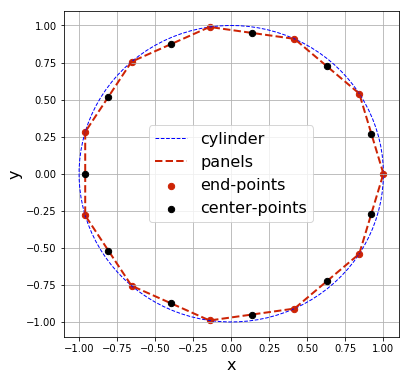

In [5]:
N_panels = 11

x_ends = R * numpy.cos(numpy.linspace(0.0, 2 * math.pi, N_panels + 1))
y_ends = R * numpy.sin(numpy.linspace(0.0, 2 * math.pi, N_panels + 1))

panels = numpy.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])

    
size = 6

pyplot.figure(figsize=(size, size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder,
            label='cylinder',
            color='b', linestyle='--', linewidth=1)
pyplot.plot(x_ends, y_ends,
            label='panels',
            color='#CD2305', linestyle='--', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels],
               label='end-points',
               color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels],
               label='center-points',
               color='k', s=40, zorder=3)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

In [6]:
def integral_normal(p_i, p_j):
   
    def integrand(s):
        return (((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.cos(p_i.beta) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.sin(p_i.beta)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [7]:

A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A, 0.5)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i, j] = 0.5 / math.pi * integral_normal(p_i, p_j)


b = - u_inf * numpy.cos([p.beta for p in panels])
A.shape

(11, 11)

In [8]:

sigma = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

In [9]:
def integral_tangential(p_i, p_j):
   
    def integrand(s):
        return ((-(p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.sin(p_i.beta) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.cos(p_i.beta)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [10]:

A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A, 0.0)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i, j] = 0.5 / math.pi * integral_tangential(p_i, p_j)

b = - u_inf * numpy.sin([panel.beta for panel in panels])


vt = numpy.dot(A, sigma) + b

for i, panel in enumerate(panels):
    panel.vt = vt[i]
vt

array([-5.63465114e-01, -1.51149915e+00, -1.97964288e+00, -1.81926399e+00,
       -1.08128163e+00, -2.54303664e-16,  1.08128163e+00,  1.81926399e+00,
        1.97964288e+00,  1.51149915e+00,  5.63465114e-01])

In [11]:

for panel in panels:
    panel.cp = 1.0 - (panel.vt / u_inf)**2

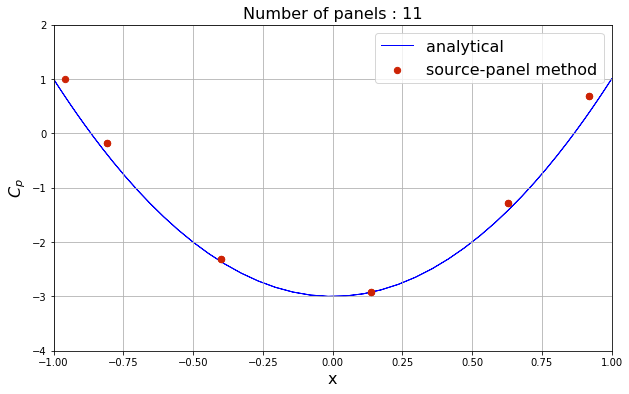

In [12]:
cp_analytical = 1.0 - 4 * (y_cylinder / R)**2

pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot(x_cylinder, cp_analytical,
            label='analytical',
            color='b', linestyle='-', linewidth=1, zorder=1)
pyplot.scatter([p.xc for p in panels], [p.cp for p in panels],
               label='source-panel method',
               color='#CD2305', s=40, zorder=2)
pyplot.title('Number of panels : %d' % N_panels, fontsize=16)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-1.0, 1.0)
pyplot.ylim(-4.0, 2.0);

In [13]:
N = 100                               
x_start, x_end = -4.0, 4.0          
y_start, y_end = -4.0, 4.0            
x = numpy.linspace(x_start, x_end, N)   
y = numpy.linspace(y_start, y_end, N)    
X, Y = numpy.meshgrid(x, y) 
len(X)

100

In [14]:
#ux velocity
def integral_xaxis(X,Y, p_j):
   
    def integrand(s):
        return (((X - (p_j.xa - math.sin(p_j.beta) * s))) /
                ((X - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (Y - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [15]:
u=numpy.zeros((N,N), dtype=float)
for i in range (len(x)):
    for j in range (len(y)):
        b=0.0   
        for p in range (N_panels):
            b = b + sigma[p]/(2*math.pi) * integral_xaxis(x[i],y[j], panels[p])
            u[j,i] = b

ux = u + u_inf * numpy.ones((N,N), dtype=float)
sigma

array([-2.16886703, -1.48026707, -0.32169278,  0.9390167 ,  1.90159501,
        2.26043034,  1.90159501,  0.9390167 , -0.32169278, -1.48026707,
       -2.16886703])

In [16]:
#ux velocity
def integral_yaxis(X,Y, p_j):
   
    def integrand(s):
        return (((Y - (p_j.ya + math.cos(p_j.beta) * s))) /
                ((X - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (Y - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [17]:
u=numpy.zeros((N,N), dtype=float)
for i in range (len(x)):
    for j in range (len(y)):
        b=0.0   
        for p in range (N_panels):
            b = b + sigma[p]/(2*math.pi) * integral_yaxis(x[i],y[j], panels[p])
            u[j,i] = b

uy = u

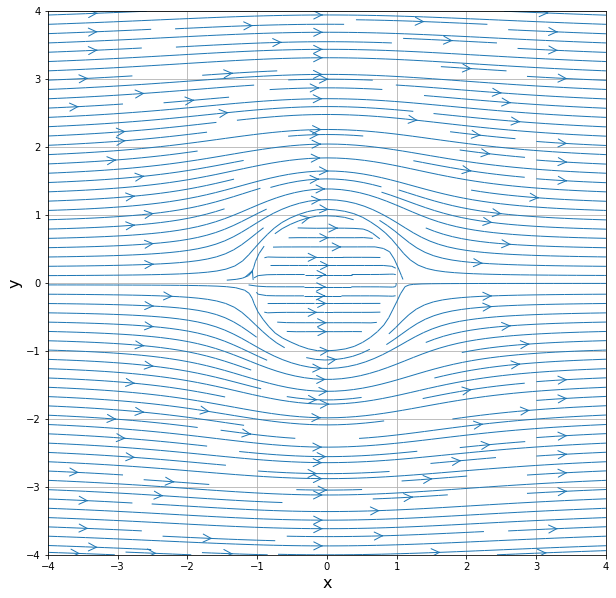

In [18]:
width = 10
height = (y_end - y_start) / (x_end - x_start) * width
pyplot.figure(figsize=(width, height))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)

pyplot.streamplot(X, Y, ux, uy,
                  density=2.0, linewidth=1, arrowsize=2, arrowstyle='->')